<a href="https://colab.research.google.com/github/solobala/DSNN18/blob/main/age_by_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import psycopg2
from psycopg2 import sql
import sqlalchemy
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
DATABASE = {
    'drivername': 'postgresql+psycopg2://',
    'host': '95.217.160.45',
    'port': '5634',
    'username': 'postgres',
    'password': 'sHiCpLUd0OIofgrvcdUnEt8rvYWjdBblPdMnnyDrb1LLK2lalAvAQ2ooIPgrcTMC',
    'database': 'postgres'
}
conn = psycopg2.connect(
    dbname=DATABASE.get('database'),
    user=DATABASE.get('username'),
    password=DATABASE.get('password'),
    host=DATABASE.get('host'),
    port=DATABASE.get('port'))
cur = conn.cursor()
%load_ext sql
# а это загрузка установленного расширения
data = pd.read_sql("select id, description, age, animal_id from pets where age is not null", conn)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<ipython-input-38-9ce56875a610>:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql("select id, description, age, animal_id from pets where age is not null", conn)


In [57]:
df=data[['description', 'age']]

In [58]:
df['len']= df['description'].apply(lambda x: len(x))

<ipython-input-58-a5fcc099229c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len']= df['description'].apply(lambda x: len(x))


In [59]:
df = df[(df['len']>63)]

In [61]:
df.head()

,description,age,len
4,Очаровательный пес Элвис 1 год ищет семью! Лас...,12,634
5,История Мухтара началась неудачно в тот самый ...,60,1765
6,Адель.\nЕе глубокий взгляд заставляет нас дума...,84,2744
7,Щенок обработан от внешних и внутренних параз...,5,252
9,Пёс Харди обладает крайне энергичным характеро...,24,764


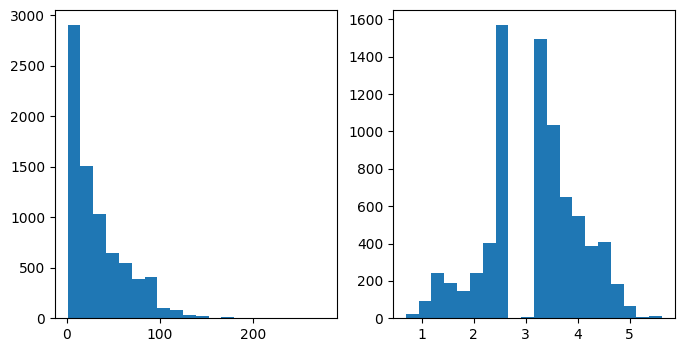

In [62]:
df['Log1page'] = np.log1p(df['age']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(df["age"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(df['Log1page'], bins=20);

In [63]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

df["description"] = df["description"].astype(str).apply(
    lambda x: ' '.join(tokenizer.tokenize(x.lower())), 1)


In [64]:
from collections import Counter

tokens = []

for title in df["description"]:
    tokens += title.split()

token_counts = Counter(tokens)

In [65]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))



Total unique tokens : 47891
(',', 91702)
('.', 64841)
('и', 39717)
('в', 23794)
('с', 17377)
...
('606', 1)
('щенок_рэдди', 1)
('щенокдаром', 1)


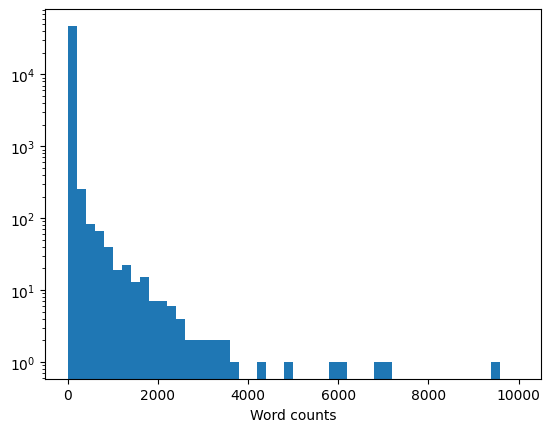

In [66]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [67]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

In [68]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 6978


In [69]:
token_to_id = {token: id for id, token in enumerate(tokens)}

In [70]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [71]:
from sklearn.model_selection import train_test_split
df=df[['description', 'Log1page']]
train, val = train_test_split(df, test_size=0.2, random_state=42)
train.index = range(len(train))
val.index = range(len(val))

print("Train size = ", len(train))
print("Validation size = ", len(val))

Train size =  6167
Validation size =  1542


In [72]:
train.shape

(6167, 2)

In [73]:
target_column = "Log1page"

In [74]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["description"] = as_matrix(df["description"].values, max_len)

    if word_dropout != 0:
        batch["description"] = apply_word_dropout(batch["description"], 1. - word_dropout)

    if target_column in df.columns:
        batch[target_column] = df[target_column].values

    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [82]:
make_batch(train[:3], max_len=10)

{'description': array([[4059, 4165, 6867, ...,    2, 2631,   38],
        [2205,    0, 3305, ..., 3082,   38, 2341],
        [ 281,   41, 1716, ..., 1682,   38, 6739],
        ...,
        [3104, 2064, 3050, ..., 2050, 5367,   38],
        [   0,   41, 2481, ..., 5859, 5140,   38],
        [2989,  216, 1051, ...,    2,  250, 6523]], dtype=int32),
 'Log1page': array([2.5649493, 4.1108737, 4.4426513, ..., 1.9459101, 3.218876 ,
        3.8918202], dtype=float32)}

In [90]:
result = make_batch(train[:100], max_len=10)
print(result['description'].shape, result['Log1page'].shape)

(7709, 10) (7709,)


In [76]:
import keras
import keras.layers as L

In [77]:
def build_model(n_tokens=len(tokens), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """

    l_descr = L.Input(shape=[None], name="description")


    # Build your monster!

    emb = L.Embedding(n_tokens, 2 * hid_size)

    l_descr_emb = emb(l_descr)
    l_descr_conv = L.Convolution1D(hid_size, kernel_size=5, activation='relu')(l_descr_emb)

    l_descr_out = L.GlobalMaxPool1D()(l_descr_conv)


    l_dense_clf = L.Dense(hid_size, activation='relu')(l_descr_out)

    output_layer = L.Dense(1)(l_dense_clf)
    # end of your code

    model = keras.models.Model(inputs=[l_descr], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model


In [93]:
model = build_model()
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 description (InputLayer)    [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 128)         893184    
                                                                 
 conv1d_9 (Conv1D)           (None, None, 64)          41024     
                                                                 
 global_max_pooling1d_9 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                           

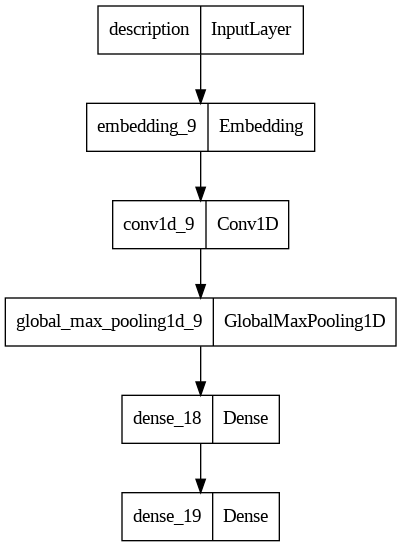

In [100]:
keras.utils.plot_model(model, "my_model.png")

In [99]:
dummy_pred = model.predict(make_batch(train['description'][:100]))
dummy_pred.shape
# assert dummy_pred.shape == (100, 1)
# assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"



241/241 [==============================] - 16s 68ms/step


(7709, 1)

In [108]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle: break

In [ ]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit_generator(iterate_minibatches(train, batch_size, cycle=True, word_dropout=0.05),
                    epochs=epochs, steps_per_epoch=steps_per_epoch,

                    validation_data=iterate_minibatches(val, batch_size, cycle=True),
                    validation_steps=val.shape[0] // batch_size
                   )

<ipython-input-109-0a9980ec1243>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(iterate_minibatches(train, batch_size, cycle=True, word_dropout=0.05),


Epoch 1/10


In [ ]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error

print_metrics(model, train, name='Train')
print_metrics(model, data_val, name='Val');